In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import akshare as ak
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
from database.downloader.downloader_base import DownloaderBase
import database.database_config as db_config

pd.options.display.max_rows=None
pd.options.display.max_columns=None

!python --version

Python 3.8.10


In [2]:
import tensorflow as tf

# 只使用CPU进行训练
tf.config.set_visible_devices([], 'GPU')

# 打印Tensorflow版本
print(f"Tensorflow Version: {tf.__version__}")

# 检查是否有可用的GPU设备
if tf.test.is_built_with_cuda():
    print("TensorFlow GPU version is installed")
else:
    print("TensorFlow CPU version is installed")

# 检查TensorFlow是否能够访问GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices available:", gpus)
else:
    print("No GPU devices found. Running on CPU.")

# !nvidia-smi

2024-03-28 06:01:40.266438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 06:01:41.222157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow Version: 2.13.1
TensorFlow GPU version is installed
GPU devices available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# 绘图相关函数
def plot_series_dist(series):
    data = series
    # 使用matplotlib画直方图
    plt.hist(data, bins=60, edgecolor='k', alpha=0.7)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Data')
    plt.show()

In [4]:
class PreProcessing:
    def __init__(self, db_downloader:DownloaderBase) -> None:
        self.db_downloader = db_downloader

    def _build_reg_label(self, stock_dataframe):
        N = 5 # 最大持仓周期 = N天，第N+1天开盘卖出
        df = stock_dataframe.copy()
        # 标签构建
        df['label'] = df['open'].shift(-N-1) / df['open'].shift(-1) - 1 # 计算第N日收益率
        # 极值处理 - quantile处理
        df['label'] = np.clip(
            df['label'], 
            np.nanquantile(df['label'], 0.01), 
            np.nanquantile(df['label'], 0.99),
            )
        # 过滤第二天一字涨停情况
        df = df[df['high'].shift(-1) != df['low'].shift(-1)]
        return df[['datetime', 'label']]
    
    # def _build_reg_label(self, stock_dataframe):
    #     N = 10  # 最大持仓周期 = N天
    #     df = stock_dataframe.copy()
    #     # 计算未来N天内的最高收盘价
    #     df['max_open_future'] = df['open'].shift(-N).rolling(window=N).max()
    #     # 计算标签：即未来N天内最大收益率
    #     df['label'] = df['max_open_future'] / df['open'].shift(-1) - 1
    #     # 可选的极值处理 - quantile处理
    #     df['label'] = np.clip(
    #         df['label'],
    #         np.nanquantile(df['label'], 0.01),
    #         np.nanquantile(df['label'], 0.99),
    #     )
    #     # 过滤第二天一字涨停情况
    #     df = df[df['high'].shift(-1) != df['low'].shift(-1)]
    #     return df[['datetime', 'label']]

    def _process_one_stock(self, stock_code, start_date, end_date):
        stock_base = self.db_downloader._download_stock_base_info(stock_code) # 获取基础代码
        stock_individual = self.db_downloader._download_stock_individual_info(stock_code) # 获取profile信息
        stock_history = self.db_downloader._download_stock_history_info(stock_code, start_date, end_date) # 获取历史行情
        stock_indicator = self.db_downloader._download_stock_indicator_info(stock_code, start_date, end_date) # 获取指标数据
        stock_factor_date = self.db_downloader._download_stock_factor_date_info() # 获取日期特征
        stock_factor_qlib = self.db_downloader._download_stock_factor_qlib_info(stock_code, start_date, end_date) # 获取量价特征
        stock_label = self._build_reg_label(stock_history) # 构建Label
        stock_df = stock_base.merge(stock_individual, on=['stock_code']).merge(stock_history, on=['stock_code']).merge(stock_indicator, on=['stock_code', 'datetime']).merge(stock_label, on=['datetime']).merge(stock_factor_date, on=['datetime']).merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_base \
            .merge(stock_individual, on=['stock_code', 'stock_name']) \
            .merge(stock_history, on=['stock_code']) \
            .merge(stock_indicator, on=['stock_code', 'datetime']) \
            .merge(stock_label, on=['datetime']) \
            .merge(stock_factor_date, on=['datetime']) \
            .merge(stock_factor_qlib, on=['stock_code', 'datetime']) # 整合数据
        stock_df = stock_df.dropna()
        return stock_df
    
    def _process_all_stock(self, code_type, start_date, end_date):
        # stock_code_list = list(ak.stock_info_a_code_name()['code'].unique()) # 获取A股所有股票列表
        stock_code_list = list(ak.index_stock_cons(code_type)['品种代码'].unique()) # 获取沪深300的股票代码列表
        stock_df_list = []
        for stock_code in tqdm(stock_code_list, desc=f'Process: {code_type} ...'):
            stock_df = self._process_one_stock(stock_code, start_date, end_date)
            if not stock_df.empty:
                stock_df_list.append(stock_df)
        return pd.concat(stock_df_list)

In [5]:
db_conn = sqlite3.connect('../database/hh_quant.db')
db_downloader = DownloaderBase(db_conn, db_config)
proprocessor = PreProcessing(db_downloader=db_downloader)

In [67]:
benchmark = '000905'
df = proprocessor._process_all_stock(code_type=benchmark, start_date='20130101', end_date='20231231')
# df = proprocessor._process_one_stock('601398', start_date='20130101', end_date='20181231')
# df = proprocessor.db_downloader._download_stock_history_info('601398', start_date='20130101', end_date='20181231')

Process: 000905 ...: 100%|██████████| 430/430 [01:07<00:00,  6.35it/s]


In [68]:
df.shape

(826230, 207)

In [69]:
def extract_train_val_data(df, train_start_date, train_end_date, val_start_date, val_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date = pd.to_datetime(train_end_date)
    val_start_date = pd.to_datetime(val_start_date)
    val_end_date = pd.to_datetime(val_end_date)
    train_data = df[(pd.to_datetime(df['datetime']) >= train_start_date) & (pd.to_datetime(df['datetime']) <= train_end_date)]
    val_data = df[(pd.to_datetime(df['datetime']) >= val_start_date) & (pd.to_datetime(df['datetime']) <= val_end_date)]

    print(f"train_data_size: {train_data.shape}")
    print(f"validation_data_size: {val_data.shape}")
    return train_data, val_data

sample_dates = ['20130101', '20181231', '20190101', '20211231']
train_data, val_data = extract_train_val_data(df, *sample_dates)

train_data_size: (357834, 207)
validation_data_size: (271740, 207)


In [78]:
feature_config = {
    "target_features": ["label"],
    "numeric_features": ['turnover_rate', 'pe_ttm', 'ps_ttm', 'pcf_ncf_ttm', 'pb_mrq', 'KMID', 'KLEN', 'KMID2', 'KUP', 'KUP2', 'KLOW', 'KLOW2', 'KSFT', 'KSFT2', 'OPEN0', 'OPEN1', 'OPEN2', 'OPEN3', 'OPEN4', 'HIGH0', 'HIGH1', 'HIGH2', 'HIGH3', 'HIGH4', 'LOW0', 'LOW1', 'LOW2', 'LOW3', 'LOW4', 'CLOSE1', 'CLOSE2', 'CLOSE3', 'CLOSE4', 'VOLUME1', 'VOLUME2', 'VOLUME3', 'VOLUME4', 'ROC5', 'ROC10', 'ROC20', 'ROC30', 'ROC60', 'MAX5', 'MAX10', 'MAX20', 'MAX30', 'MAX60', 'MIN5', 'MIN10', 'MIN20', 'MIN30', 'MIN60', 'MA5', 'MA10', 'MA20', 'MA30', 'MA60', 'STD5', 'STD10', 'STD20', 'STD30', 'STD60', 'BETA5', 'BETA10', 'BETA20', 'BETA30', 'BETA60', 'RSQR5', 'RSQR10', 'RSQR20', 'RSQR30', 'RSQR60', 'RESI5', 'RESI10', 'RESI20', 'RESI30', 'RESI60', 'QTLU5', 'QTLU10', 'QTLU20', 'QTLU30', 'QTLU60', 'QTLD5', 'QTLD10', 'QTLD20', 'QTLD30', 'QTLD60', 'TSRANK5', 'TSRANK10', 'TSRANK20', 'TSRANK30', 'TSRANK60', 'RSV5', 'RSV10', 'RSV20', 'RSV30', 'RSV60', 'IMAX5', 'IMAX10', 'IMAX20', 'IMAX30', 'IMAX60', 'IMIN5', 'IMIN10', 'IMIN20', 'IMIN30', 'IMIN60', 'IMXD5', 'IMXD10', 'IMXD20', 'IMXD30', 'IMXD60', 'CORR5', 'CORR10', 'CORR20', 'CORR30', 'CORR60', 'CORD5', 'CORD10', 'CORD20', 'CORD30', 'CORD60', 'CNTP5', 'CNTP10', 'CNTP20', 'CNTP30', 'CNTP60', 'CNTN5', 'CNTN10', 'CNTN20', 'CNTN30', 'CNTN60', 'CNTD5', 'CNTD10', 'CNTD20', 'CNTD30', 'CNTD60', 'SUMP5', 'SUMP10', 'SUMP20', 'SUMP30', 'SUMP60', 'SUMN5', 'SUMN10', 'SUMN20', 'SUMN30', 'SUMN60', 'SUMD5', 'SUMD10', 'SUMD20', 'SUMD30', 'SUMD60', 'VMA5', 'VMA10', 'VMA20', 'VMA30', 'VMA60', 'VSTD5', 'VSTD10', 'VSTD20', 'VSTD30', 'VSTD60', 'WVMA5', 'WVMA10', 'WVMA20', 'WVMA30', 'WVMA60', 'VSUMP5', 'VSUMP10', 'VSUMP20', 'VSUMP30', 'VSUMP60', 'VSUMN5', 'VSUMN10', 'VSUMN20', 'VSUMN30', 'VSUMN60', 'VSUMD5', 'VSUMD10', 'VSUMD20', 'VSUMD30', 'VSUMD60'],
    "integer_categorical_features": ['month'],
    "string_categorical_features": ['industry', 'season'],
}
features_columns = feature_config.get('numeric_features', []) + \
                        feature_config.get('integer_categorical_features', []) + \
                        feature_config.get('string_categorical_features', [])
label_columns = feature_config.get('target_features', [])

full_columns = features_columns + label_columns

train_df, val_df = train_data[full_columns], val_data[full_columns]

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, StandardScaler

preprocessing_pipeline = Pipeline([
        ('quantile_transformer', QuantileTransformer(output_distribution='uniform', n_quantiles=1000)),
    ])

numeric_feature_columns = feature_config.get('numeric_features', [])
train_df[numeric_feature_columns] = preprocessing_pipeline.fit_transform(train_df[numeric_feature_columns])
val_df[numeric_feature_columns] = preprocessing_pipeline.transform(val_df[numeric_feature_columns])

In [59]:
def df_to_dataset(dataframe, feature_cols, label_cols, shuffle=True, batch_size=32):
    features = dataframe[feature_cols]
    labels = dataframe[label_cols]
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(features), 10000))
    ds = ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

batch_size = 512
train_ds = df_to_dataset(train_df, features_columns, label_columns, shuffle=True, batch_size=batch_size)
val_ds = df_to_dataset(val_df, features_columns, label_columns, shuffle=False, batch_size=batch_size)

In [60]:
from model.layers import DnnLayer, BitWiseSeNet


class QuantModel(tf.keras.Model):
    def __init__(self, config, **kwargs):
        super(QuantModel, self).__init__(**kwargs)
        self.config = config
        self.lookup_layers = {}
        self.embedding_layers = {}

        # 创建整数特征的查找层和嵌入层
        for feature_name, vocab in self.config.get("integer_categorical_features_with_vocab").items():
            self.lookup_layers[feature_name] = tf.keras.layers.IntegerLookup(vocabulary=vocab, name=f"{feature_name}_lookup")
            self.embedding_layers[feature_name] = tf.keras.layers.Embedding(
                input_dim=len(vocab) + 1, 
                output_dim=self.config.get("feature_embedding_dims", 4), 
                embeddings_initializer=tf.keras.initializers.glorot_normal(self.config.get('seed', 1024)),
                name=f"{feature_name}_embedding"
            )
        # 创建字符串特征的查找层和嵌入层
        for feature_name, vocab in self.config.get("string_categorical_features_with_vocab").items():
            self.lookup_layers[feature_name] = tf.keras.layers.StringLookup(vocabulary=vocab, name=f"{feature_name}_lookup")
            self.embedding_layers[feature_name] = tf.keras.layers.Embedding(
                input_dim=len(vocab) + 1, 
                output_dim=self.config.get("feature_embedding_dims", 4), 
                embeddings_initializer=tf.keras.initializers.glorot_normal(self.config.get('seed', 1024)),
                name=f"{feature_name}_embedding"
            )

            # 自定义层相关
        self.bitwise_senet_layer = BitWiseSeNet(
            reduction_ratio=self.config.get("reduction_ratio", 3),
            l2_reg=self.config.get("l2_reg", 0.0),
            seed=self.config.get("seed", 1024),
        )
        self.dnn_layer = DnnLayer(
            hidden_units=self.config.get("dnn_hidden_units", [64, 32]),
            activation=self.config.get("dnn_activation", "relu"),
            dropout_rate=self.config.get("dnn_dropout", 0.2),
            use_bn=self.config.get("dnn_use_bn", True),
            l2_reg=self.config.get("l2_reg", 0.001),
            seed=self.config.get("seed", 1024),
        )

        self.wide_output_layer = tf.keras.layers.Dense(1, activation=None)
        self.deep_output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        if not isinstance(inputs, dict):
            raise ValueError("The inputs to the model should be a dictionary where keys are feature names.")
        # 处理Deep侧特征 - 首先使用seNet进行特征权重调整
        dense_features = [] # [B, N]
        encode_features = [] # list of [B, emb]
        for feature_name, feature_value in inputs.items():
            if feature_name in self.lookup_layers:
                lookup_layer = self.lookup_layers[feature_name]
                embedding_layer = self.embedding_layers[feature_name]
                encode_feature = embedding_layer(lookup_layer(feature_value))
                encode_features.append(encode_feature)
            else:
                dense_features.append(feature_value)
        dense_emb = tf.stack(dense_features, axis=-1)
        encode_emb = tf.concat(encode_features, axis=-1)
        # print(f"dense_emb_shape: {dense_emb.get_shape()}")
        # print(f"encode_emb_shape: {encode_emb.get_shpe()}")
        
        # ..........................................................................................
        # 处理Wide侧DNN特征
        wide_logit = self.wide_output_layer(dense_emb)
        # ..........................................................................................

        # ..........................................................................................
        # 处理Deep侧DNN特征
        deep_output = tf.concat([dense_emb, encode_emb], axis=-1)
        deep_output = self.bitwise_senet_layer(deep_output, training=training)
        deep_output = self.dnn_layer(deep_output, training=training)
        deep_logit = self.deep_output_layer(deep_output)
        # ..........................................................................................

        final_logit = deep_logit + wide_logit
        return final_logit
    

    def get_config(self):
        # 调用基类的get_config方法（如果基类实现了get_config）
        config = super(QuantModel, self).get_config()
        # 添加QuantModel特有的配置信息
        config.update(
            {
                # 假设self.config是一个可序列化的字典，如果不是，你可能需要在这里适当地处理它
                "config": self.config
            }
        )
        return config
    
model_config = {
        "seed": 1024,
        "feature_embedding_dims": 4,
        "integer_categorical_features_with_vocab": {k: list(train_data[k].unique()) for k in feature_config.get('integer_categorical_features', [])},
        "string_categorical_features_with_vocab": {k: list(train_data[k].unique()) for k in feature_config.get('string_categorical_features', [])},
    }
model = QuantModel(config=model_config)

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps=(len(train_data) // batch_size)*10,
    decay_rate=1,
    staircase=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanSquaredError(),
    ]
)

EPOCHS = 500

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

baseline_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [early_stopping],
)

Epoch 1/500


2024-03-28 07:26:32.470106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 156472 of 357834
2024-03-28 07:26:42.470075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 312886 of 357834


  1/699 [..............................] - ETA: 5:02:35 - loss: 1.5664 - mean_absolute_error: 1.4249 - mean_squared_error: 3.2195

2024-03-28 07:26:45.331942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 82s 80ms/step - loss: 0.2969 - mean_absolute_error: 0.1975 - mean_squared_error: 0.1723 - val_loss: 0.1384 - val_mean_absolute_error: 0.0736 - val_mean_squared_error: 0.0086
Epoch 2/500


2024-03-28 07:27:51.335042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 158517 of 357834
2024-03-28 07:28:01.335045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 314383 of 357834


  5/699 [..............................] - ETA: 24s - loss: 0.1292 - mean_absolute_error: 0.0646 - mean_squared_error: 0.0168   

2024-03-28 07:28:04.055885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 71s 69ms/step - loss: 0.0970 - mean_absolute_error: 0.0551 - mean_squared_error: 0.0123 - val_loss: 0.0727 - val_mean_absolute_error: 0.0482 - val_mean_squared_error: 0.0043
Epoch 3/500


2024-03-28 07:29:02.122704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 161262 of 357834
2024-03-28 07:29:12.122720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 316069 of 357834


  5/699 [..............................] - ETA: 25s - loss: 0.0729 - mean_absolute_error: 0.0485 - mean_squared_error: 0.0042   

2024-03-28 07:29:14.886918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 72s 70ms/step - loss: 0.0625 - mean_absolute_error: 0.0472 - mean_squared_error: 0.0040 - val_loss: 0.0555 - val_mean_absolute_error: 0.0467 - val_mean_squared_error: 0.0041
Epoch 4/500


2024-03-28 07:30:14.156965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 169316 of 357834
2024-03-28 07:30:24.156940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 326937 of 357834


  5/699 [..............................] - ETA: 24s - loss: 0.0530 - mean_absolute_error: 0.0443 - mean_squared_error: 0.0036   

2024-03-28 07:30:26.147127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 70s 69ms/step - loss: 0.0514 - mean_absolute_error: 0.0458 - mean_squared_error: 0.0038 - val_loss: 0.0515 - val_mean_absolute_error: 0.0481 - val_mean_squared_error: 0.0042
Epoch 5/500


2024-03-28 07:31:24.546940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 165746 of 357834
2024-03-28 07:31:34.546938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 317763 of 357834


  5/699 [..............................] - ETA: 25s - loss: 0.0493 - mean_absolute_error: 0.0460 - mean_squared_error: 0.0038   

2024-03-28 07:31:38.459045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 72s 69ms/step - loss: 0.0471 - mean_absolute_error: 0.0448 - mean_squared_error: 0.0037 - val_loss: 0.0490 - val_mean_absolute_error: 0.0474 - val_mean_squared_error: 0.0043
Epoch 6/500


2024-03-28 07:32:37.021230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 166937 of 357834
2024-03-28 07:32:47.021249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 331851 of 357834


  5/699 [..............................] - ETA: 22s - loss: 0.0467 - mean_absolute_error: 0.0451 - mean_squared_error: 0.0037   

2024-03-28 07:32:48.680777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 69s 68ms/step - loss: 0.0453 - mean_absolute_error: 0.0440 - mean_squared_error: 0.0036 - val_loss: 0.0482 - val_mean_absolute_error: 0.0472 - val_mean_squared_error: 0.0043
Epoch 7/500


2024-03-28 07:33:46.335741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 165948 of 357834
2024-03-28 07:33:56.335718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 327968 of 357834


  5/699 [..............................] - ETA: 23s - loss: 0.0449 - mean_absolute_error: 0.0439 - mean_squared_error: 0.0036   

2024-03-28 07:33:58.342889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 67s 65ms/step - loss: 0.0444 - mean_absolute_error: 0.0435 - mean_squared_error: 0.0035 - val_loss: 0.0492 - val_mean_absolute_error: 0.0484 - val_mean_squared_error: 0.0042
Epoch 8/500


2024-03-28 07:34:53.868755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 169137 of 357834
2024-03-28 07:35:03.868792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 337194 of 357834


  5/699 [..............................] - ETA: 20s - loss: 0.0437 - mean_absolute_error: 0.0429 - mean_squared_error: 0.0034   

2024-03-28 07:35:05.157274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 68s 67ms/step - loss: 0.0440 - mean_absolute_error: 0.0432 - mean_squared_error: 0.0035 - val_loss: 0.0478 - val_mean_absolute_error: 0.0470 - val_mean_squared_error: 0.0041
Epoch 9/500


2024-03-28 07:36:02.206458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 168504 of 357834
2024-03-28 07:36:12.206501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 331216 of 357834


  3/699 [..............................] - ETA: 28s - loss: 0.0428 - mean_absolute_error: 0.0420 - mean_squared_error: 0.0033    

2024-03-28 07:36:14.146575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 75s 76ms/step - loss: 0.0434 - mean_absolute_error: 0.0426 - mean_squared_error: 0.0034 - val_loss: 0.0536 - val_mean_absolute_error: 0.0529 - val_mean_squared_error: 0.0050
Epoch 10/500


2024-03-28 07:37:17.048994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 166563 of 357834
2024-03-28 07:37:27.048940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 330154 of 357834


  5/699 [..............................] - ETA: 23s - loss: 0.0441 - mean_absolute_error: 0.0434 - mean_squared_error: 0.0035   

2024-03-28 07:37:29.008485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 75s 75ms/step - loss: 0.0430 - mean_absolute_error: 0.0423 - mean_squared_error: 0.0033 - val_loss: 0.0501 - val_mean_absolute_error: 0.0494 - val_mean_squared_error: 0.0043
Epoch 11/500


2024-03-28 07:38:31.928431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 164626 of 357834
2024-03-28 07:38:41.928410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 326368 of 357834


  3/699 [..............................] - ETA: 26s - loss: 0.0414 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0030    

2024-03-28 07:38:44.129358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 69s 67ms/step - loss: 0.0426 - mean_absolute_error: 0.0420 - mean_squared_error: 0.0033 - val_loss: 0.0488 - val_mean_absolute_error: 0.0482 - val_mean_squared_error: 0.0042
Epoch 12/500


2024-03-28 07:39:41.085921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 161570 of 357834
2024-03-28 07:39:51.085855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 315333 of 357834


  3/699 [..............................] - ETA: 27s - loss: 0.0426 - mean_absolute_error: 0.0420 - mean_squared_error: 0.0032    

2024-03-28 07:39:53.934237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 78s 79ms/step - loss: 0.0425 - mean_absolute_error: 0.0419 - mean_squared_error: 0.0033 - val_loss: 0.0534 - val_mean_absolute_error: 0.0528 - val_mean_squared_error: 0.0047
Epoch 13/500


2024-03-28 07:40:59.484511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 163095 of 357834
2024-03-28 07:41:09.484521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 322694 of 357834


  5/699 [..............................] - ETA: 26s - loss: 0.0419 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0032   

2024-03-28 07:41:11.855474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 74s 74ms/step - loss: 0.0422 - mean_absolute_error: 0.0417 - mean_squared_error: 0.0033 - val_loss: 0.0468 - val_mean_absolute_error: 0.0463 - val_mean_squared_error: 0.0041
Epoch 14/500


2024-03-28 07:42:13.803853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 164020 of 357834
2024-03-28 07:42:23.803859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 318545 of 357834


  5/699 [..............................] - ETA: 26s - loss: 0.0415 - mean_absolute_error: 0.0410 - mean_squared_error: 0.0032   

2024-03-28 07:42:26.577229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 72s 70ms/step - loss: 0.0419 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0032 - val_loss: 0.0472 - val_mean_absolute_error: 0.0466 - val_mean_squared_error: 0.0042
Epoch 15/500


2024-03-28 07:43:25.424346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 162557 of 357834
2024-03-28 07:43:35.424340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 325270 of 357834


  5/699 [..............................] - ETA: 24s - loss: 0.0405 - mean_absolute_error: 0.0400 - mean_squared_error: 0.0030   

2024-03-28 07:43:37.604598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 68s 66ms/step - loss: 0.0418 - mean_absolute_error: 0.0413 - mean_squared_error: 0.0032 - val_loss: 0.0466 - val_mean_absolute_error: 0.0461 - val_mean_squared_error: 0.0040
Epoch 16/500


2024-03-28 07:44:33.437781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 164791 of 357834
2024-03-28 07:44:43.437763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 329010 of 357834


  5/699 [..............................] - ETA: 26s - loss: 0.0409 - mean_absolute_error: 0.0404 - mean_squared_error: 0.0031   

2024-03-28 07:44:45.430339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 70s 68ms/step - loss: 0.0416 - mean_absolute_error: 0.0411 - mean_squared_error: 0.0032 - val_loss: 0.0466 - val_mean_absolute_error: 0.0461 - val_mean_squared_error: 0.0041
Epoch 17/500


2024-03-28 07:45:43.233562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 164144 of 357834
2024-03-28 07:45:53.233487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 332973 of 357834


  5/699 [..............................] - ETA: 22s - loss: 0.0414 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0033   

2024-03-28 07:45:54.756177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 66s 64ms/step - loss: 0.0414 - mean_absolute_error: 0.0409 - mean_squared_error: 0.0032 - val_loss: 0.0472 - val_mean_absolute_error: 0.0468 - val_mean_squared_error: 0.0041
Epoch 18/500


2024-03-28 07:46:49.778812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 163810 of 357834
2024-03-28 07:46:59.778848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 328475 of 357834


  5/699 [..............................] - ETA: 22s - loss: 0.0413 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0031   

2024-03-28 07:47:01.749806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 69s 68ms/step - loss: 0.0413 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0031 - val_loss: 0.0470 - val_mean_absolute_error: 0.0466 - val_mean_squared_error: 0.0042
Epoch 19/500


2024-03-28 07:47:58.988977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 160684 of 357834
2024-03-28 07:48:08.988949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 321463 of 357834


  3/699 [..............................] - ETA: 25s - loss: 0.0432 - mean_absolute_error: 0.0428 - mean_squared_error: 0.0034    

2024-03-28 07:48:11.624213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 72s 70ms/step - loss: 0.0412 - mean_absolute_error: 0.0408 - mean_squared_error: 0.0031 - val_loss: 0.0475 - val_mean_absolute_error: 0.0471 - val_mean_squared_error: 0.0041
Epoch 20/500


2024-03-28 07:49:10.687409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 165666 of 357834
2024-03-28 07:49:20.687353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 335129 of 357834


  5/699 [..............................] - ETA: 22s - loss: 0.0411 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0031   

2024-03-28 07:49:22.067454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 66s 63ms/step - loss: 0.0410 - mean_absolute_error: 0.0406 - mean_squared_error: 0.0031 - val_loss: 0.0504 - val_mean_absolute_error: 0.0500 - val_mean_squared_error: 0.0044
Epoch 21/500


2024-03-28 07:50:16.460048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 167598 of 357834
2024-03-28 07:50:26.459997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 336501 of 357834


  5/699 [..............................] - ETA: 21s - loss: 0.0407 - mean_absolute_error: 0.0403 - mean_squared_error: 0.0029   

2024-03-28 07:50:27.834641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 66s 64ms/step - loss: 0.0409 - mean_absolute_error: 0.0405 - mean_squared_error: 0.0031 - val_loss: 0.0469 - val_mean_absolute_error: 0.0465 - val_mean_squared_error: 0.0041
Epoch 22/500


2024-03-28 07:51:22.862333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 167593 of 357834
2024-03-28 07:51:32.862345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 327501 of 357834


  3/699 [..............................] - ETA: 24s - loss: 0.0409 - mean_absolute_error: 0.0405 - mean_squared_error: 0.0031    

2024-03-28 07:51:34.925346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 70s 68ms/step - loss: 0.0408 - mean_absolute_error: 0.0404 - mean_squared_error: 0.0031 - val_loss: 0.0477 - val_mean_absolute_error: 0.0473 - val_mean_squared_error: 0.0043
Epoch 23/500


2024-03-28 07:52:32.822155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 165838 of 357834
2024-03-28 07:52:42.822144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 329185 of 357834


  5/699 [..............................] - ETA: 25s - loss: 0.0392 - mean_absolute_error: 0.0388 - mean_squared_error: 0.0028   

2024-03-28 07:52:44.618243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 74s 74ms/step - loss: 0.0407 - mean_absolute_error: 0.0403 - mean_squared_error: 0.0031 - val_loss: 0.0506 - val_mean_absolute_error: 0.0502 - val_mean_squared_error: 0.0044
Epoch 24/500


2024-03-28 07:53:46.399128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 165788 of 357834
2024-03-28 07:53:56.399098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 330640 of 357834


  5/699 [..............................] - ETA: 23s - loss: 0.0411 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0031   

2024-03-28 07:53:58.185461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 68s 66ms/step - loss: 0.0405 - mean_absolute_error: 0.0401 - mean_squared_error: 0.0031 - val_loss: 0.0468 - val_mean_absolute_error: 0.0464 - val_mean_squared_error: 0.0042
Epoch 25/500


2024-03-28 07:54:54.486954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 166083 of 357834
2024-03-28 07:55:04.481375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 330347 of 357834


  5/699 [..............................] - ETA: 23s - loss: 0.0411 - mean_absolute_error: 0.0407 - mean_squared_error: 0.0031   

2024-03-28 07:55:06.390440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


699/699 [==============================] - 69s 68ms/step - loss: 0.0405 - mean_absolute_error: 0.0401 - mean_squared_error: 0.0031 - val_loss: 0.0482 - val_mean_absolute_error: 0.0478 - val_mean_squared_error: 0.0041
Epoch 25: early stopping


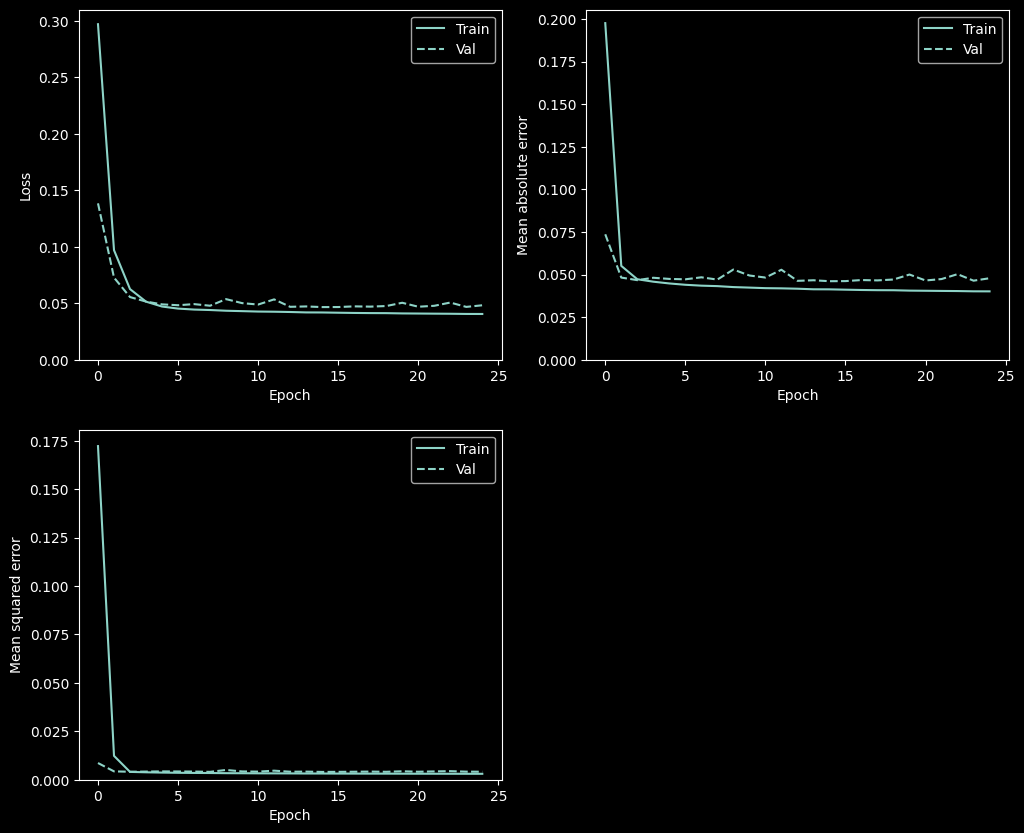

In [64]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'mean_absolute_error', 'mean_squared_error']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.ylim([0, plt.ylim()[1]])
    plt.legend()

plot_metrics(baseline_history)

loss :  0.04658547416329384
mean_absolute_error :  0.04607889801263809
mean_squared_error :  0.004021011292934418

527/527 [==============================] - 24s 46ms/step
Accuracy: 0.52, Precision: 0.52, Recall: 0.60


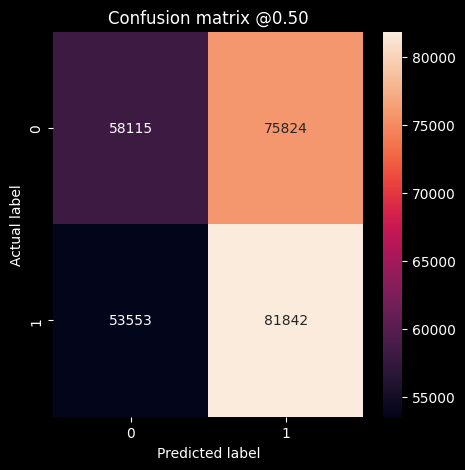

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

def plot_cm(true_labels, pred_labels, p=0.5):
    cm = confusion_matrix(true_labels, pred_labels > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")


baseline_results = model.evaluate(val_ds, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

true_labels = val_data['label']
pred_labels = model.predict(val_ds)

true_label = (np.array(true_labels) > 0).astype(int)
pred_label = (np.array(pred_labels) > 0).astype(int)

plot_cm(true_label, pred_label)

In [83]:
model_pred_result = model.predict(val_ds)
output_df = val_data[['stock_code', 'industry', 'stock_name', 'datetime']]
# 回归结果
output_df['label'] = val_data['label']
output_df['label_pred'] = model_pred_result
output_df.to_pickle(f'../../Offline/backtest/backtest_data/{benchmark}/stock_selection_results_20190101.pkl')

  1/531 [..............................] - ETA: 39s

531/531 [==============================] - 23s 43ms/step


In [84]:
# # 9. 配置保存模型功能
# model_save_path = f'./models/saved_model/model_of_20240328_reg'
# model.save(model_save_path)
# best_model = tf.keras.models.load_model(model_save_path)

In [6]:
backtest_start_date = '20190101'
backtest_end_date = '20240101'
train_period = 6 # year：训练数据周期长度
update_period = 6 # month：模型更新周期长度

def get_rolling_date_period(backtest_start_date, backtest_end_date, training_period, update_period):
    backtest_start_date = datetime.strptime(backtest_start_date, '%Y%m%d')
    backtest_end_date = datetime.strptime(backtest_end_date, '%Y%m%d')
    result = []
    rolling_flag = True
    while rolling_flag:
        current_val_start_date = backtest_start_date
        current_val_end_date = current_val_start_date + relativedelta(months=update_period) - relativedelta(days=1)
        if current_val_start_date < backtest_end_date:
            current_train_start_date = current_val_start_date - relativedelta(years=training_period)
            current_train_end_date = current_val_start_date - relativedelta(days=1)
            result.append([
                current_train_start_date.strftime("%Y%m%d"),
                current_train_end_date.strftime("%Y%m%d"),
                current_val_start_date.strftime("%Y%m%d"),
                current_val_end_date.strftime("%Y%m%d")
                ])
            backtest_start_date += relativedelta(months=update_period) 
        else:
            rolling_flag=False # 结束滚动训练
    return result

rolling_period = get_rolling_date_period(backtest_start_date, backtest_end_date, train_period, update_period)
rolling_period

[['20130101', '20181231', '20190101', '20190630'],
 ['20130701', '20190630', '20190701', '20191231'],
 ['20140101', '20191231', '20200101', '20200630'],
 ['20140701', '20200630', '20200701', '20201231'],
 ['20150101', '20201231', '20210101', '20210630'],
 ['20150701', '20210630', '20210701', '20211231'],
 ['20160101', '20211231', '20220101', '20220630'],
 ['20160701', '20220630', '20220701', '20221231'],
 ['20170101', '20221231', '20230101', '20230630'],
 ['20170701', '20230630', '20230701', '20231231']]

In [ ]:
# model.summary()
# model_config